In [1]:
#Imports
%matplotlib inline
# %pylab osx

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Some additional libraries
from libs.utils import montage
from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

#Bit of formatting 
from IPython.core.display import HTML
HTML("""<style> . rendered_html_code {
     padding: 2px 4px;
     background-color: #f9f2f4;
     border-radius: 4px
} </style>""")

In [ ]:
from libs.datasets import MNIST
ds = MNIST()

In [ ]:
#We will try to encode the image to learn interesting fetaure from image 
print(ds.X.shape)

In [ ]:
#if we try to dsiplay the image then we have to reshape the image by 28 X 28 insead of one giant matrix of 784 pixels.

plt.imshow(ds.X[0].reshape((28,28)))

In [ ]:
#Lets take first 1000 images of datasets and reshape them

imgs = ds.X[:1000].reshape((-1,28,28))

#Then create a monage 
plt.imshow(montage(imgs), cmap='gray')

In [ ]:
#take a mean across all images
mean_imgs = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_imgs.reshape((28,28)), cmap='gray')

In [ ]:
#and the standard deviation
std_imgs = np.std(ds.X, axis=0)
plt.figure()
plt.imshow(std_imgs.reshape((28,28)), cmap='gray')

In [ ]:
#This is mainly showing what basicaaly constant across all images and what is changing 
#and autoencoder is going to try to encode what is changing in the images.

#In order to encode information in the images we are going to build series of fully connected layers
#which will get progressively smaller - every pixle of 784 pixeled image will act like neuron

dimension = [512, 256, 128, 64] # Progressive reduction of image dims from 784 to reduced dim of power of 2

In [ ]:
n_features = ds.X.shape[1]
print(n_features)
X = tf.placeholder(tf.float32, [None, n_features])

In [ ]:
#Now we are going to build a network which will perform series of multplication on X and then add a bias, at thend add 
# a non-linearity

current_input = X
n_input = n_features
Ws = []

for layer_i, n_output in enumerate(dimension):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        #Create a weight matrix which will increasingly reduce
        #information in the input image by performing matrix multiplication
        
        W = tf.get_variable(
            name="W",
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        
        #current_output = tf.nn.relu(h)
        Ws.append(W)
        n_input = n_output

In [ ]:
print(current_input.get_shape())

In [ ]:
#Now in order to do decoding and get back to original image we need to reverse everything we did so far

Ws = Ws[::-1]

dimension = dimension[::-1][1:] + [ds.X.shape[1]]
print(dimension)

In [ ]:
for layer_i, n_output in enumerate(dimension):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        #Create a weight matrix which will increasingly reduce
        #information in the input image by performing matrix multiplication
        
        W = tf.transpose(Ws[layer_i])
        
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        
    
        n_input = n_output

In [ ]:
y = current_input

In [ ]:
cost = tf.reduce_mean(tf.squared_difference(X, y),1)
print(cost.get_shape())

In [ ]:
cost = tf.reduce_mean(cost)

In [ ]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
batch_size = 100
n_epochs = 1


examples = ds.X[:100]

imgs = []


fig, ax = plt.subplots(1,1)

for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_imgs})
        recon = sess.run(y, feed_dict={X: examples - mean_imgs})
        recon = np.clip((recon + mean_imgs).reshape((-1, 28, 28)), 0, 255)
        img_i = montage(recon).astype(np.uint8)
        imgs.append(img_i)
        ax.imshow(img_i, cmap='gray')
        fig.canvas.draw()
        print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_imgs}))

In [ ]:
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [ ]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()), height=500, width=500)

In [ ]:
#Convolutional Autoencoder:

from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [ ]:
X = tf.placeholder(tf.float32, [None, n_features])

In [ ]:
print(X.get_shape())

In [ ]:
#Now for convolution we need 4-D tensor of N x H x W x C 
X_tensor = tf.reshape(X, [-1, 28,28, 1])

In [ ]:
#We will use 16 filters of shape 4 X 4 in three conv layer
n_filters = [16, 16, 16]
filter_size = [4,4,4]

In [ ]:
current_input = X_tensor
n_input = 1
Ws = []
shapes = []

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        #we will keep track of shapes of output volume of each layer
        shapes.append(current_input.get_shape().as_list())
        #Create a weight matrix which will increasingly reduce the 
        #information from input to three layers
        W = tf.get_variable(
            name = "W",
            shape = [
                    filter_size[layer_i],
                    filter_size[layer_i],
                    n_input,
                    n_output],
                 initializer=tf.random_normal_initializer(mean=0.0, stddev=0.2))
        
        h = tf.nn.conv2d(current_input, W, strides = [1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output

In [ ]:
#we have built our convolution encoder and stored weights. Now we will decode using the stored weights

Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters = n_filters[1:]  [1]

print(n_filters, filter_size, shapes)

In [ ]:
#loop through out convolution filters and get back our inout images
# we will enumerate the shapes list to get us there
for layer_i, shape in enumerate(shapes):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        #we will keep track of shapes of output volume of each layer
        #shapes.append(current_input.get_shape().as_list())
        #Create a weight matrix which will increasingly reduce the 
        #information from input to three layers
        W = Ws[layer_i]
        h = tf.nn.conv2d_transpose(current_input, W, 
                                   tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
                                   strides=[1,2,2,1], padding='SAME')
        
        
        current_input = tf.nn.relu(h)

In [ ]:
y = current_input
y = tf.reshape(y, [-1, n_features])

In [ ]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, y),1))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 100
n_epochs = 1


examples = ds.X[:100]

imgs = []


fig, ax = plt.subplots(1,1)

for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_imgs})
        recon = sess.run(y, feed_dict={X: examples - mean_imgs})
        recon = np.clip((recon + mean_imgs).reshape((-1, 28, 28)), 0, 255)
        img_i = montage(recon).astype(np.uint8)
        imgs.append(img_i)
        ax.imshow(img_i, cmap='gray')
        fig.canvas.draw()
        print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_imgs}))
        
gif.build_gif(imgs, saveto=ae.gif, cmap='gray')

In [ ]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()), height=500, width=500)

In [ ]:
#Denoising Autoencoder, Variational Autoencoder

## Input image is corrupted using masked noise on the input data, then model is shown noisy data and 
##reconstruction loss is calculated against original input
##Variational autoencoder use two separate network adding one more variational layer and backpropagate to optimize both layer
##then connected using clever reparametization trick.

from libs import datasets

In [ ]:
ds = datasets.MNIST(one_hot=True)
#Lets look at the first level

print(ds.Y[0])
#Okay what does the input look like

plt.imshow(np.reshape(ds.X[0], (28,28)), cmap='gray')
#great it is just the label of the image

In [ ]:
plt.figure()
print(ds.Y[1])
plt.imshow(np.reshape(ds.X[1], (28,28)), cmap='gray')

In [ ]:
ds = datasets.MNIST(one_hot=True)
plt.figure()
plt.imshow(np.reshape(ds.X[0], (28,28)), cmap='gray')
print(ds.Y[0])
plt.imshow(np.reshape(ds.X[1], (28,28)), cmap='gray')
print(ds.Y[1])

In [ ]:
print(ds.X.shape)

In [ ]:
print(ds.Y.shape)
print(ds.Y[0])

In [ ]:
#cost= tf.reduce_sum(tf.abs(y_pred - y_true)

In [4]:
#Fully connected network

import tensorflow as tf
from libs import datasets
ds = datasets.MNIST(split=[0.8,0.1,0.1])
n_input = 28 * 28

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
n_output = 10

In [6]:
X = tf.placeholder(tf.float32, [None, n_input])

In [7]:
Y = tf.placeholder(tf.float32, [None, n_output])

In [8]:
from libs import utils
Y_pred, W = utils.linear(
       x = X,
       n_output = n_output,
       activation = tf.nn.softmax, 
       name = 'layer1')

In [9]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred+1e-12)) #adding a very small number 1e-12 to avoid log of 0 as its is indefinite
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

In [10]:
predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y , 1)

In [11]:
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 50
n_epochs = 1

for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict= {
                    X: batch_xs,
                    Y: batch_ys
                 })
        valid = ds.valid
        print(sess.run(accuracy,
                       feed_dict={
                           X: valid.images,
                           Y: valid.labels
                       }))
#Final test accuracy       
test = ds.test
print(sess.run(accuracy,
               feed_dict = {
                    X: test.images,
                    Y: test.labels
               }))

0.0487143
0.069
0.092
0.118857
0.139286
0.159571
0.176286
0.197429
0.22
0.241
0.269286
0.295286
0.322571
0.350429
0.376143
0.395714
0.414286
0.432143
0.451286
0.468857
0.483286
0.503286
0.518714
0.536714
0.554143
0.573143
0.587286
0.600429
0.613286
0.626143
0.637714
0.648714
0.654429
0.662857
0.670429
0.676714
0.685286
0.693143
0.699857
0.703857
0.707429
0.711857
0.714571
0.718571
0.723
0.726143
0.727429
0.73
0.732429
0.736571
0.738
0.740714
0.742286
0.744714
0.747714
0.751286
0.752857
0.755571
0.757143
0.759571
0.761286
0.761571
0.763143
0.765571
0.767286
0.769857
0.771429
0.773857
0.776
0.778714
0.782
0.783429
0.784286
0.786286
0.786714
0.787571
0.788286
0.789143
0.790286
0.791143
0.792429
0.793286
0.793429
0.794429
0.794143
0.795143
0.794857
0.797429
0.798429
0.799571
0.801
0.801571
0.802571
0.802286
0.803714
0.805143
0.806286
0.806571
0.808714
0.810714
0.812
0.811857
0.812
0.813429
0.815
0.815143
0.816143
0.816
0.817143
0.818571
0.82
0.820571
0.820286
0.820857
0.821286
0.823286
0.8

In [13]:
#Inspecting the trained network
# We first get the graph that we used to compute the network

g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[u'Placeholder',
 u'Placeholder_1',
 u'layer1/W',
 u'layer1/W/Initializer/random_uniform/shape',
 u'layer1/W/Initializer/random_uniform/min',
 u'layer1/W/Initializer/random_uniform/max',
 u'layer1/W/Initializer/random_uniform/RandomUniform',
 u'layer1/W/Initializer/random_uniform/sub',
 u'layer1/W/Initializer/random_uniform/mul',
 u'layer1/W/Initializer/random_uniform',
 u'layer1/W/Assign',
 u'layer1/W/read',
 u'layer1/b',
 u'layer1/b/Initializer/Const',
 u'layer1/b/Assign',
 u'layer1/b/read',
 u'layer1/MatMul',
 u'layer1/h',
 u'layer1/Softmax',
 u'add/y',
 u'add',
 u'Log',
 u'mul',
 u'Const',
 u'Sum',
 u'Neg',
 u'gradients/Shape',
 u'gradients/Const',
 u'gradients/Fill',
 u'gradients/Neg_grad/Neg',
 u'gradients/Sum_grad/Reshape/shape',
 u'gradients/Sum_grad/Reshape',
 u'gradients/Sum_grad/Shape',
 u'gradients/Sum_grad/Tile',
 u'gradients/mul_grad/Shape',
 u'gradients/mul_grad/Shape_1',
 u'gradients/mul_grad/BroadcastGradientArgs',
 u'gradients/mul_grad/mul',
 u'gradients/mul_grad/Sum'

In [14]:
W = g.get_tensor_by_name('layer1/W:0')

In [15]:
import numpy as np
W_arr = np.array(W.eval(session=sess))
print(W_arr.shape)

(784, 10)


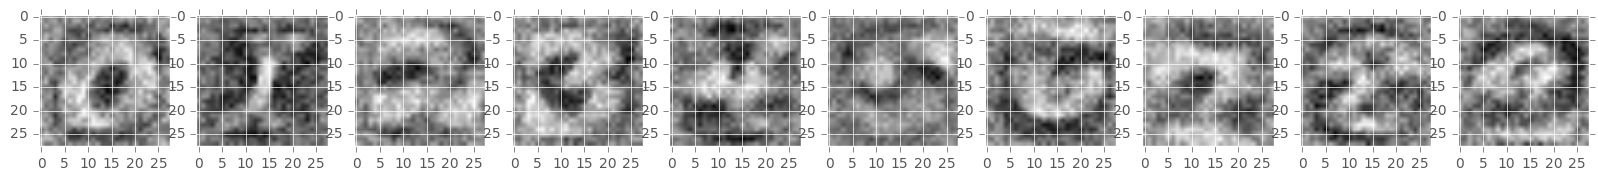

In [16]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for col_i in range(10):
    ax[col_i].imshow(W_arr[:, col_i].reshape((28,28)), cmap='gray')

In [17]:
#Convolutinal network 
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [18]:
#We will placeholders just like before which we will fill in later
ds = datasets.MNIST(one_hot=True, split=[0.8,0.1,0.1])
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None,10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [19]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [20]:
filter_size = 5
n_filters_in = 1
n_filters_out = 32
W_1 = tf.get_variable(
      name='W',
      shape=[filter_size, filter_size, n_filters_in, n_filters_out],
      initializer=tf.random_normal_initializer())

In [21]:
b_1 = tf.get_variable(
      name='b',
      shape=[n_filters_out],
      initializer=tf.constant_initializer())

In [22]:
h_1 = tf.nn.relu(
     tf.nn.bias_add(
     tf.nn.conv2d(input=X_tensor,
                    filter = W_1,
                       strides = [1,2,2,1],
                       padding='SAME'), b_1))

In [23]:
n_filters_in = 32
n_filters_out = 64
W_2 = tf.get_variable(
      name='W2',
      shape=[filter_size, filter_size, n_filters_in, n_filters_out],
      initializer=tf.random_normal_initializer())
b_2 = tf.get_variable(
      name='b2',
      shape=[n_filters_out],
      initializer=tf.constant_initializer())
h_2 = tf.nn.relu(
     tf.nn.bias_add(
          tf.nn.conv2d(input=h_1,
                    filter = W_2,
                       strides = [1,2,2,1],
                       padding='SAME'), b_2))

In [24]:
h_2_flat = tf.reshape(h_2, [-1, 7*7*n_filters_out])

In [25]:
h_3, W = utils.linear(h_2_flat, 128, activation=tf.nn.relu, name='fc_1')

In [26]:
Y_pred, W = utils.linear(h_3, n_output, activation=tf.nn.softmax, name='fc_2')

In [27]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

In [28]:
correct_prediction = tf.equal(tf.argmax(Y_pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
batch_size = 50
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs,
            Y: batch_ys
        })
    valid = ds.valid
    print(sess.run(accuracy,
                  feed_dict={
                      X: valid.images,
                      Y: valid.labels
                  }))
    
test = ds.test
print(sess.run(accuracy,
              feed_dict={
                  X: test.images,
                  Y: test.labels
              }))

0.945
0.962571
0.961
0.970857
0.972857
0.974714
0.975
0.973143
0.976429
0.975714
0.971571


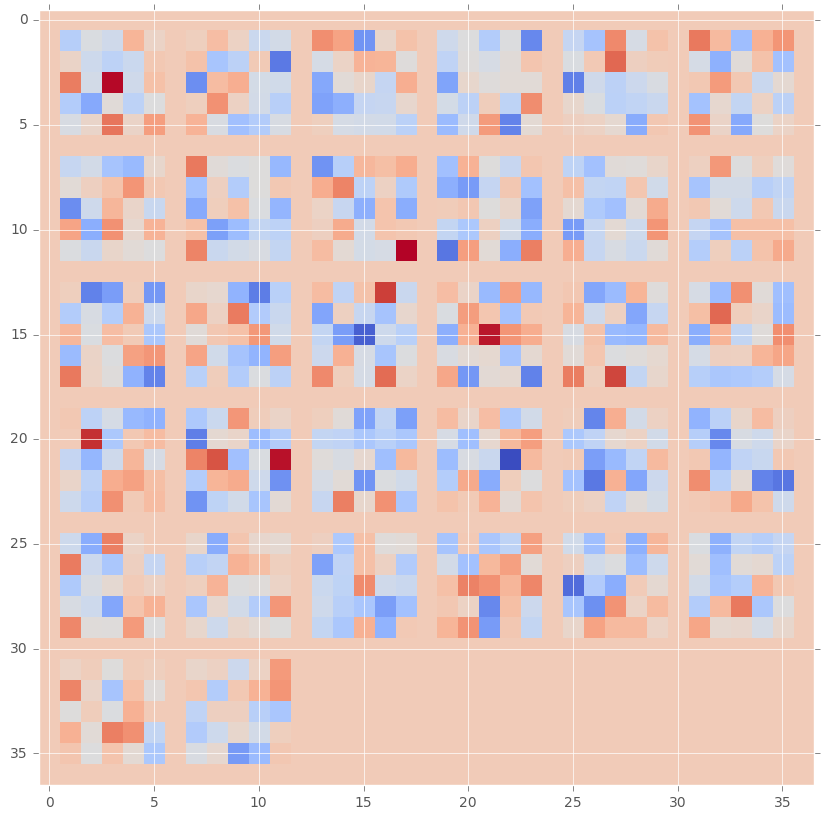

In [31]:
from libs.utils import montage_filters
W1 = sess.run(W_1)
plt.figure(figsize=(10,10))
plt.imshow(montage_filters(W1), cmap='coolwarm', interpolation='nearest')

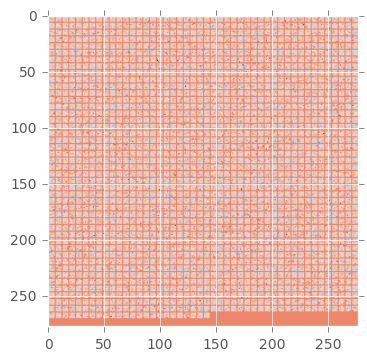

In [32]:
W2 = sess.run(W_2)
plt.imshow(montage_filters(W2 / np.max(W2)), cmap='coolwarm')

In [40]:
import os

sess = tf.Session()
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
sess.run(init_op)
if os.path.exists("model.ckpt"):
    saver.restore(sess, "model.ckpt")
    print("Model restored.")

In [41]:
save_path = saver.save(sess, "./model.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./model.ckpt


In [42]:
path='./'
ckpt_name = './model.ckpt'
fname = 'model.tfmodel'
dst_nodes = ['Y']
g_1 = tf.Graph()
with tf.Session(graph=g_1) as sess:
    x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
    # Replace this with some code which will create your tensorflow graph:
    #net = create_network()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, ckpt_name)
    graph_def = tf.python.graph_util.convert_variables_to_constants(
        sess, sess.graph_def, dst_nodes)
g_2 = tf.Graph()
with tf.Session(graph=g_2) as sess:
    tf.train.write_graph(
        tf.python.graph_util.extract_sub_graph(
            graph_def, dst_nodes), path, fname, as_text=False)

TypeError: Cannot interpret feed_dict key as Tensor: The name 'save_1/Const:0' refers to a Tensor which does not exist. The operation, 'save_1/Const', does not exist in the graph.

In [ ]:
with open("model.tfmodel", mode='rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(net['graph_def'], name='model')